In [1]:
import csv
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Convolution2D, MaxPooling2D, Cropping2D
import matplotlib.pyplot as plt

# Plot inline
%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 32
data_path = 'data'
img_folder = 'IMG'
csv_file_name = 'driving_log.csv'

In [3]:
# Read in data
samples = []
csv_full_path = data_path + '/'+ csv_file_name
img_path = data_path + '/' + img_folder
print(csv_full_path, img_path)

data/driving_log.csv data/IMG


In [4]:
with open(csv_full_path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [5]:
samples[0]

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

In [6]:
del samples[0]
samples[0]

['IMG\\center_2016_12_01_13_30_48_287.jpg',
 'IMG\\left_2016_12_01_13_30_48_287.jpg',
 'IMG\\right_2016_12_01_13_30_48_287.jpg',
 '0.0',
 '0.0',
 '0.0',
 '22.14829']

In [7]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [8]:
crop_top = 60
crop_bottom = 130
crop_left = 0
crop_right = 320

In [9]:
#name = data_path + '/' + samples[10][0].split('/')[-1]
#print(name)
#center_image = cv2.imread(name)
#plt.imshow(center_image)
#print(center_image.shape)

In [10]:
#cropped_image = center_image[crop_top:crop_bottom, crop_left:crop_right]
#plt.imshow(cropped_image)
#print(cropped_image.shape)

In [11]:
#r = 64.0 / cropped_image.shape[1]
#dim = (64, int(center_image.shape[0] * r))
#dim = (64, 64)

# perform the actual resizing of the image and show it
#resized = cv2.resize(cropped_image, dim, interpolation = cv2.INTER_AREA)
#plt.imshow(resized)
#print(resized.shape)

In [12]:
from sklearn.utils import shuffle
correction_factor = 0.2

def generator(samples, batch_size=32):
    N = (len(samples)//batch_size)*batch_size  # make the number of samples a multiple of batch_size

    X_batch = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
    y_batch = np.zeros((batch_size,), dtype=np.float32)    
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, N, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            for j,batch_sample in enumerate(batch_samples):
                img_pos_choice = np.random.choice([0,1,2])
                name = data_path + '/'+ batch_sample[img_pos_choice].split('/')[-1]
                #print(name)
                image = cv2.imread(name) # reads BGR format
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # To RGB format
                cropped_image = image[crop_top:crop_bottom, crop_left:crop_right]
                resized_image = cv2.resize(cropped_image, (64,64))

                if img_pos_choice == 0:
                    angle = float(batch_sample[3])

                if img_pos_choice == 1:
                    angle = float(batch_sample[3]) + correction_factor

                if img_pos_choice == 2: 
                    angle = float(batch_sample[3]) - 0.25
                
                # decide whether to horizontally flip the image:
                flip_prob = np.random.random()
                if flip_prob > 0.5:
                    # flip the image and reverse the steering angle
                    angle = -1*angle
                    resized_image = cv2.flip(resized_image, 1)

                X_batch[j] = resized_image
                y_batch[j] = angle

            yield X_batch, y_batch

In [13]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [14]:
filter1_kernel_size = 5
filter2_kernel_size = 3
image_shape = (64, 64, 3)

Epoch 1/5
14432/14432 [==============================] - 503s - loss: 0.0244 - val_loss: 0.0214
Epoch 2/5
14432/14432 [==============================] - 417s - loss: 0.0213 - val_loss: 0.0202
Epoch 3/5
14432/14432 [==============================] - 476s - loss: 0.0200 - val_loss: 0.0193
Epoch 4/5
14432/14432 [==============================] - 413s - loss: 0.0194 - val_loss: 0.0187
Epoch 5/5
14432/14432 [==============================] - 325s - loss: 0.0187 - val_loss: 0.0183
dict_keys(['loss', 'val_loss'])


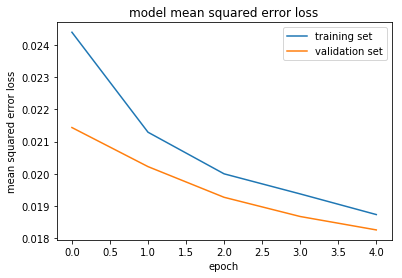

In [15]:
# Initialize the model
model = Sequential()
# Pre-processing: Normalizing and mean centered
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape = image_shape))
model.add(Convolution2D(nb_filter = 6, nb_row = filter1_kernel_size, nb_col = filter1_kernel_size, activation = "relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(nb_filter = 6, nb_row = filter1_kernel_size, nb_col = filter1_kernel_size, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120, activation = "relu"))
model.add(Dense(84, activation = "relu"))
model.add(Dense(10, activation = "relu"))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit_generator(train_generator, samples_per_epoch =
    (len(train_samples)//batch_size)*batch_size, validation_data = validation_generator, 
    nb_val_samples = len(validation_samples), nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')